In [1]:
# Import packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import yfinance as yf

import time
import datetime

In [2]:
bgn_date = datetime.datetime(1997, 1, 1)
end_date = datetime.datetime(2025, 3, 1)

In [3]:
# Download the monthly data of KOSPI Composite Index (KS11) from Yahoo Finance.
# I use the Python package 'yfinance' here.
bgn = bgn_date.strftime('%Y-%m-%d')
end = end_date.strftime('%Y-%m-%d')
df = yf.download('^KS11', start=bgn, end=end, interval='1mo')
ks11 = df.Close # closing price
ks11.columns = ['KS11']

# Compute the monthly return.
kret = ks11.pct_change()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
ks11.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 338 entries, 1997-01-01 to 2025-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KS11    338 non-null    float64
dtypes: float64(1)
memory usage: 5.3 KB


In [25]:
# Download the monthly data of 3-month rate of Certificates of Deposit (CD)
# I use the API provided by Bank of Korea here. Visit https://ecos.bok.or.kr/api/#/ for more information.
api_key = '632I5C2UO70SSTEUU4GP' # API key masked; You can put your own key.
bgn = bgn_date.strftime('%Y%m')
end = end_date.strftime('%Y%m')

# Set url for API request.
url = f'https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/400/721Y001/M/{bgn}/{end}/2010000/?/?/?'

# Request data and convert it to a dataframe.
response = requests.get(url)
# print(response.status_code)
data = response.json()['StatisticSearch']['row']
df1 = pd.DataFrame(data)
df1 = df1.loc[:, ['TIME', 'DATA_VALUE']]
df1.columns = ['Date', 'CD3M']
df1.Date = pd.to_datetime(df1.Date.str[:4] + '-' + df1.Date.str[4:])
df1.CD3M = df1.CD3M.astype(float)
df1.set_index('Date', drop=True, inplace=True)

# The raw data is quoted in annual percentage term:
# Divide it by 100 and convert it to monthly term by dividing it by 12.
cd3m = df1 / 1200

# Download the monthly data of CPI.
url = f'https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/400/901Y009/M/{bgn}/{end}/0/?/?/?'
response = requests.get(url)
data = response.json()['StatisticSearch']['row']
df2 = pd.DataFrame(data)
df2 = df2.loc[:, ['TIME', 'DATA_VALUE']]
df2.columns = ['Date', 'CPI']
df2.Date = pd.to_datetime(df2.Date.str[:4] + '-' + df2.Date.str[4:])
df2.CPI = df2.CPI.astype(float)
df2.set_index('Date', drop=True, inplace=True)

# Convert CPI to the monthly inflation rate
infl = df2.pct_change()

# Nominal-to-Real transformation
rcd3m = pd.DataFrame((1 + cd3m.CD3M) / (1 + infl.CPI) - 1, columns=['RCD3M'])
rret = pd.DataFrame((1 + kret.KS11) / (1 + infl.CPI) - 1, columns=['RRET'])

# Merge datasets and drop the data of year 1997.
df = pd.concat([rcd3m, rret], axis=1)
df.drop(pd.date_range('1997-01', '1997-12', freq='MS'), inplace=True)

In [26]:
ret = (1 + df).cumprod()

In [27]:
ret.loc['1997-12-01', :] = [1, 1]
ret.sort_index(inplace=True)

In [28]:
ret

,RCD3M,RRET
Date,,
1997-12-01,1.000000,1.000000
1998-01-01,0.995563,1.472706
1998-02-01,0.997032,1.426349
1998-03-01,1.017540,1.229550
1998-04-01,1.031223,1.073011
...,...,...
2024-11-01,1.436111,3.366347
2024-12-01,1.433728,3.274414
2025-01-01,1.427423,3.411526


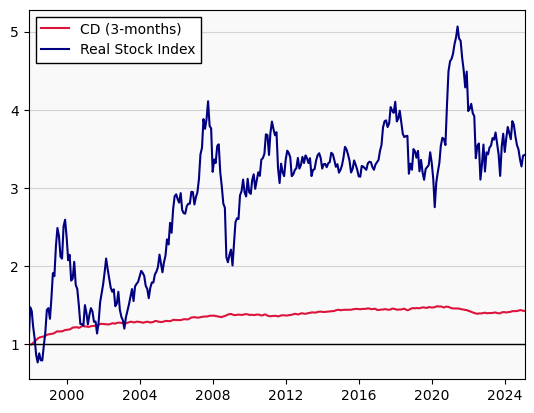

In [31]:
fig, ax = plt.subplots()

ax.plot(ret.RCD3M, label='CD (3-months)', color='crimson')
ax.plot(ret.RRET, label='Real Stock Index', color='navy')
ax.axhline(1, lw=1, color='k')

ax.set_facecolor('#F9F9F9')
ax.grid(axis='y', color='lightgray')
ax.legend(fancybox=False, edgecolor='k', framealpha=1)
ax.set_xmargin(0)

fig.savefig('./fig1.png')

In [94]:
# Question 2

bgn = bgn_date.strftime('%YQ1')
end = end_date.strftime('%YQ4')

# Download the quartley CD, data.
url = f'https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/400/721Y001/Q/{bgn}/{end}/2010000/?/?/?'
response = requests.get(url)
data = response.json()['StatisticSearch']['row']
df1 = pd.DataFrame(data)
df1 = df1.loc[:, ['TIME', 'DATA_VALUE']]
df1.columns = ['Date', 'CD3M']
# df1.Date = pd.to_datetime(df1.Date.str[:4] + '-' + df1.Date.str[4:])
df1.CD3M = df1.CD3M.astype(float)
df1.set_index('Date', drop=True, inplace=True)
cd3m = (df1 / 100).drop('2025Q1')

url = f'https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/400/901Y009/Q/{bgn}/{end}/0/?/?/?'
response = requests.get(url)
data = response.json()['StatisticSearch']['row']
df2 = pd.DataFrame(data)
df2 = df2.loc[:, ['TIME', 'DATA_VALUE']]
df2.columns = ['Date', 'CPI']
# df2.Date = pd.to_datetime(df2.Date.str[:4] + '-' + df2.Date.str[4:])
df2.CPI = df2.CPI.astype(float)
df2.set_index('Date', drop=True, inplace=True)

# Construct the quarterly stock return data.
ks11_quarterly = ks11[ks11.index.month.isin([3, 6, 9, 12])]
ks11_quarterly.index = df2.index
kret_quarterly = ks11_quarterly.pct_change()

# Compute inflation rate and real stock return.
infl = df2.pct_change()
rret = pd.DataFrame((1 + kret_quarterly.KS11) / (1 + infl.CPI) - 1, columns=['RRET'])
rcd3m = pd.DataFrame((1 + cd3m.CD3M) / (1 + infl.CPI) - 1, columns=['RCD3M'])


# Download the consumption data.
url = f'https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/400/200Y141/Q/{bgn}/{end}/10113/?/?/?'
response = requests.get(url)
data = response.json()['StatisticSearch']['row']
df3 = pd.DataFrame(data)
df3 = df3.loc[:, ['TIME', 'DATA_VALUE']]
df3.columns = ['Date', 'C']
# df1.Date = pd.to_datetime(df1.Date.str[:4] + '-' + df1.Date.str[4:])
df3.C = df3.C.astype(float)
df3.set_index('Date', drop=True, inplace=True)



# Compute annual consumption growth rate
ΔC = df3.pct_change(4).dropna()

In [88]:
ΔC

,C
Date,
1998Q1,-0.099479
1998Q2,-0.119405
1998Q3,-0.108167
1998Q4,-0.086009
1999Q1,0.079991
...,...
2023Q4,-0.001589
2024Q1,0.000493
2024Q2,0.002452


In [99]:
rret

,RRET
Date,
1997Q1,NaN
1997Q2,0.089386
1997Q3,-0.140287
1997Q4,-0.426815
1998Q1,0.214447
...,...
2023Q4,0.070006
2024Q1,0.027667
2024Q2,0.015510


In [104]:
er = pd.DataFrame(rret.loc['1998Q1':].values - rcd3m.loc['1998Q1':].values, index=ΔC.index, columns=['ER']) * 4

In [105]:
er_bar = er.mean()

In [106]:
σc = ΔC.std(ddof=1) * 2
meanc = ΔC.mean() * 4

In [107]:
rret

,RRET
Date,
1997Q1,NaN
1997Q2,0.089386
1997Q3,-0.140287
1997Q4,-0.426815
1998Q1,0.214447
...,...
2023Q4,0.070006
2024Q1,0.027667
2024Q2,0.015510


In [123]:
γ = er_bar.values / np.cov(ΔC.values.reshape(-1), rret.loc['1998Q1':].values.reshape(-1))[0, 1]

In [125]:
print(γ)

[82.59217069]


In [120]:
rret

,RRET
Date,
1997Q1,NaN
1997Q2,0.089386
1997Q3,-0.140287
1997Q4,-0.426815
1998Q1,0.214447
...,...
2023Q4,0.070006
2024Q1,0.027667
2024Q2,0.015510
